## Notebook to analyze TH MH_Tac2
Medial habenula, medium sized subclass group

In [37]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [38]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig

# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [39]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
# TH MH_Tac2 is a medium large sized subclass within dataset
gluTypes = gluData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

,Count
TH Prkcd_Grin2c,23362
TH_Rxfp1_Epb4,10411
TH PVT_Ntrk1,5419
TH/HY Gbx2 Zim1,5006
TH MH_Tac2,4405
TH AV_Col27a1,3011
TH PF_Fzd5,2500
TH LH_Pou4f1_Sox1,1346
TH Tfap2d,774
TH Serpinb7,398


In [42]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "TH MH_Tac2"
genesRanked = pd.DataFrame(
        {key: gluData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False)
genesRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Kctd8,0.0,110.320114,12.169743,1.000000,0.436253,0.563747
1,Nwd2,0.0,110.283981,16.058285,1.000000,0.302146,0.697854
2,Cacnb3,0.0,109.644447,7.905544,0.998184,0.685554,0.312630
3,Syt9,0.0,109.500801,7.448813,0.999092,0.840160,0.158932
4,Cacna1e,0.0,109.236816,7.615669,1.000000,0.695832,0.304168
...,...,...,...,...,...,...,...
23426,Kcnq3,0.0,-108.767555,-13.745298,0.124631,0.988437,-0.863806
23427,Cit,0.0,-109.312584,-13.163325,0.166856,0.995088,-0.828232
23428,Rab3c,0.0,-109.440483,-7.861966,0.721453,0.998375,-0.276922
23429,Cacna1a,0.0,-109.790222,-13.140602,0.105789,0.995088,-0.889299


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TH MH_Tac2 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

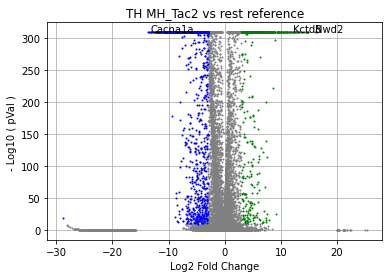

In [6]:
# Create volcano plot
plotVolcano(gluData,indx,label=["Kctd8","Nwd2","Cacna1a"])

In [43]:
# Take top 500 "score" genes
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
genesFiltered = genesRanked.iloc[0:500,:]
genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
genesFiltered

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
7,Pou4f1,0.0,109.102936,14.816555,0.997049,0.031685,0.965364
19,Ano1,0.0,107.443077,16.506626,0.973439,0.014586,0.958853
20,D130079A08Rik,0.0,107.382538,14.640830,0.981158,0.024562,0.956596
31,Hhip,0.0,104.603989,14.536981,0.949149,0.022427,0.926722
18,Syt6,0.0,107.464005,13.536032,0.980931,0.054508,0.926423
...,...,...,...,...,...,...,...
23386,Kcnc1,0.0,-104.874260,-11.791743,0.057208,0.958982,-0.901774
23407,Sez6l,0.0,-106.987411,-12.253057,0.067196,0.975514,-0.908318
23403,Shisa9,0.0,-106.557159,-13.400845,0.055846,0.970186,-0.914340
23417,Cacna1b,0.0,-108.322578,-11.964034,0.071964,0.987625,-0.915661


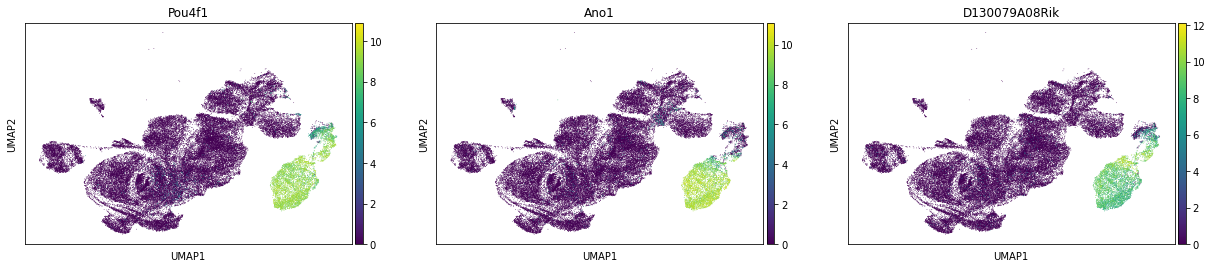

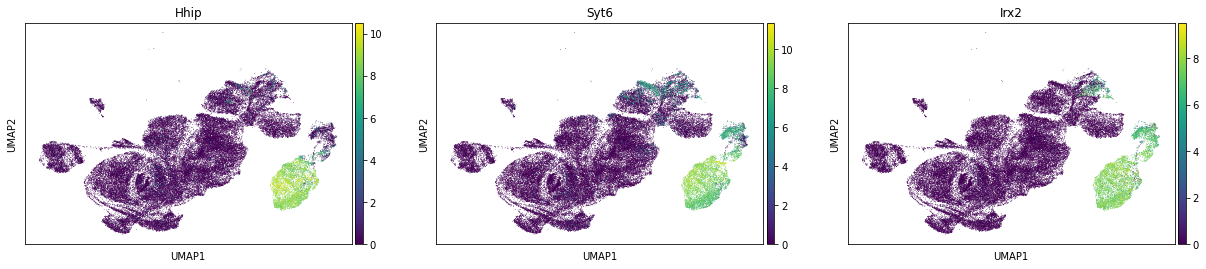

In [44]:
# Plot expression of several potential marker genes
# These genes are highly expressed in MH, but not elsewhere
sc.pl.umap(gluData, color = genesFiltered["names"][0:3])
sc.pl.umap(gluData, color = genesFiltered["names"][3:6])

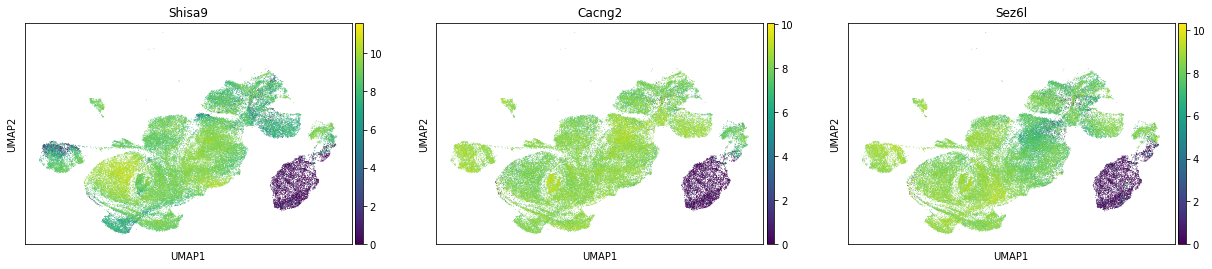

In [32]:
# Plot expression of several genes which are expressed elsewhere, but not MH
sc.pl.umap(gluData, color = ["Shisa9", "Cacng2", "Sez6l"])

In [47]:
# Look at marker gene overlap
markerGenes = {
    'Upregulated' : genesFiltered["names"][:5].tolist(),
    'Downregulated' : genesFiltered["names"][-5:].tolist(),
    'Assorted' : ["Slc17a6", "Nrn1", "Cacna2d1", "Shox2", "Pcsk2"],
}
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", top_n_markers=50, inplace=False)
markerOverlap

,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
Upregulated,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Downregulated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Assorted,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


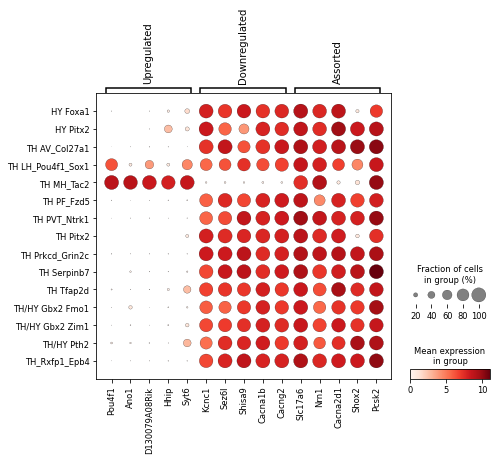

In [48]:
# Dotplot of marker gene expression in various groups
sc.pl.dotplot(gluData,markerGenes,"subclass_label", dendrogram = False)

## MH_Tac2 subcluster analysis
Look at how different various clusters within the medial habenula subclass differ

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


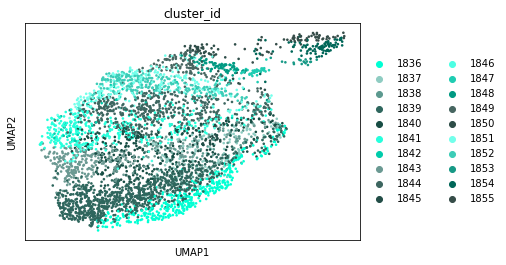

In [10]:
# Index by cell class
indx = "TH MH_Tac2"
clData = gluData[gluData.obs.subclass_label == indx]
color_dict = dict(zip(clData.obs["cluster_id"],clData.obs["cluster_color"]))
sc.pl.umap(clData, color="cluster_id",palette=color_dict)

In [11]:
# Get counts of each cluster type
clTypes = clData.obs.cluster_id.unique()
clCounts = pd.DataFrame([sum(clData.obs.cluster_id == name) for name in clTypes], columns= ["Count"], index = clTypes)
clCounts = clCounts.sort_values(by = "Count", ascending=False)
clCounts

,Count
1839,1009
1844,494
1836,424
1841,365
1843,336
1840,318
1851,277
1852,259
1837,212
1849,148


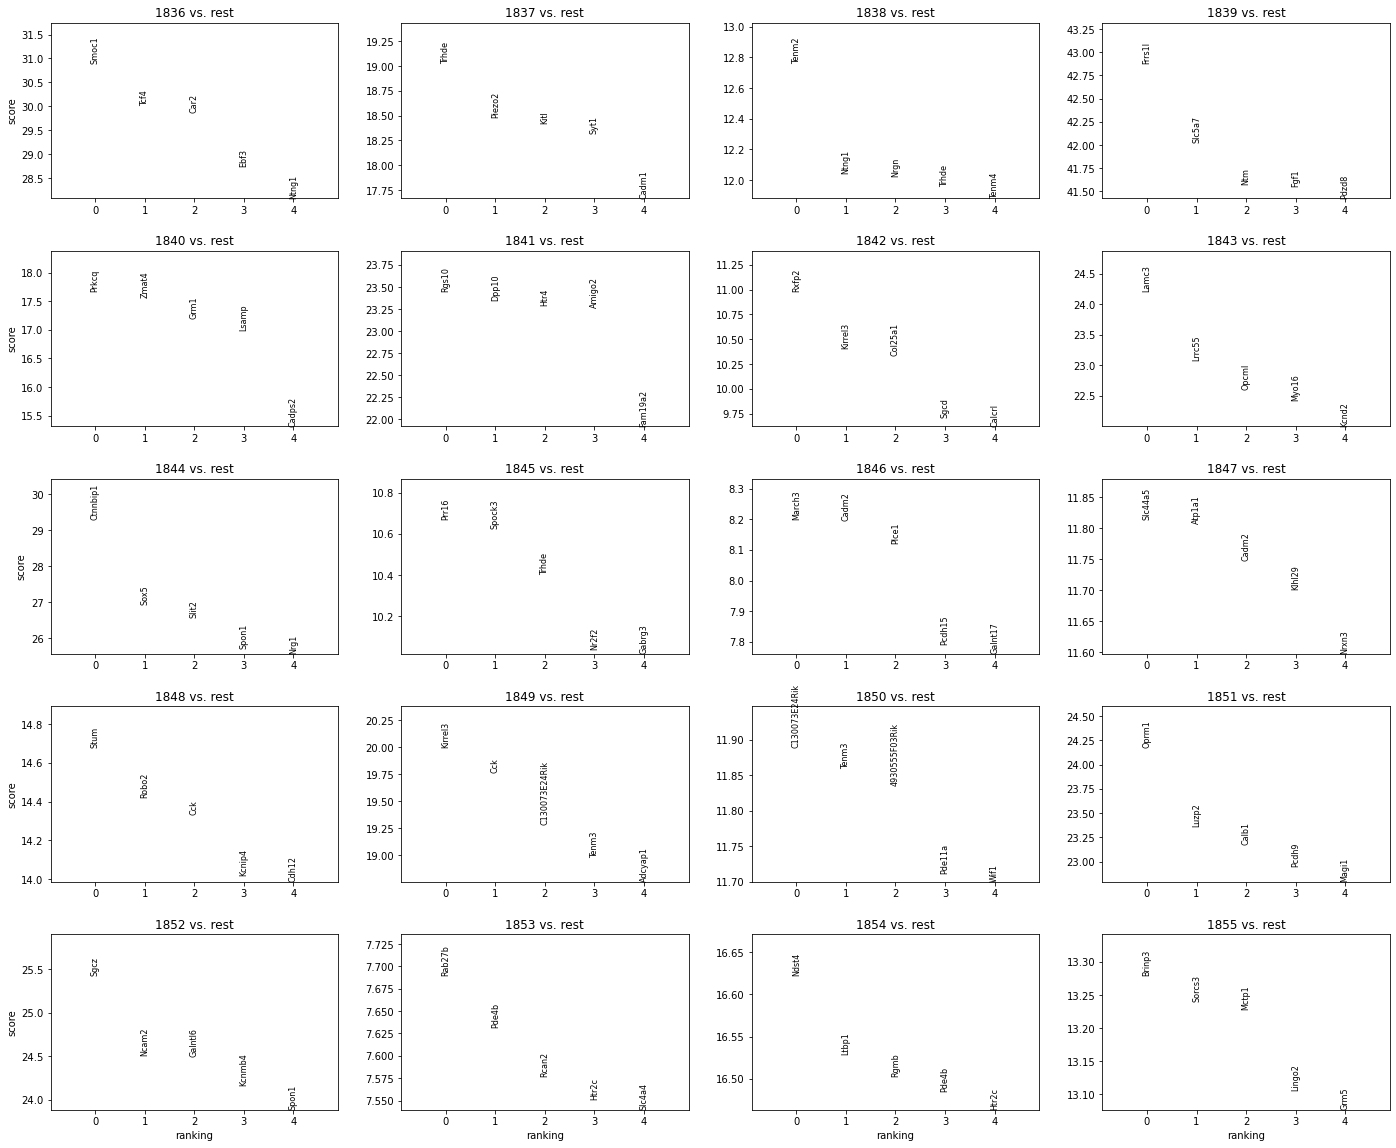

In [16]:
# Look for differential expression between clusters
sc.tl.rank_genes_groups(clData, 'cluster_id', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(clData, n_genes=5, sharey=False)

In [65]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "1851"
clRanked = pd.DataFrame(
        {key: clData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = clData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = clData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
clRanked = pd.concat([clRanked, pts, pts_rest, pts_diff], axis=1)
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Oprm1,3.447233e-129,24.181927,9.232350,1.000000,1.000000,0.000000
1,Luzp2,9.950965e-121,23.363918,8.938653,1.000000,1.000000,0.000000
2,Calb1,7.617139e-119,23.177851,9.536217,0.169675,0.360707,-0.191032
3,Pcdh9,1.383478e-116,22.952742,3.523525,0.133574,0.103924,0.029650
4,Magi1,5.403612e-115,22.792809,2.516577,0.996390,0.998304,-0.001914
...,...,...,...,...,...,...,...
10374,Wfdc15b,1.000000e+00,0.000000,0.000000,0.494585,0.235223,0.259362
10373,Svs2,1.000000e+00,0.000000,0.000000,0.996390,0.972141,0.024248
10372,Svs3b,1.000000e+00,0.000000,0.000000,0.184116,0.105136,0.078980
10371,Svs4,1.000000e+00,0.000000,0.000000,0.083032,0.077519,0.005513


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'1851 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

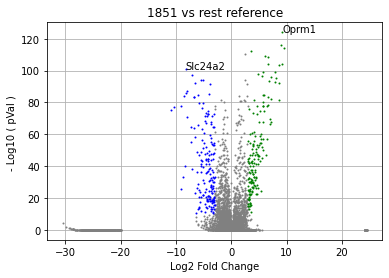

In [66]:
# Query volcano plots for various clusters
plotVolcano(clData,indx)

In [67]:
# Take top 500 "score" genes, filtered out for atleast 2 logfold change
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clFiltered = clRanked.iloc[0:500,:]
clFiltered = clFiltered[clFiltered["logfoldchanges"] > abs(2)]
clFiltered = clFiltered.sort_values(by=["pts_diff"], ascending=False)
clFiltered

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
199,Kctd4,9.516600e-30,11.328176,3.023042,0.902527,0.443556,0.458971
102,Wif1,6.577934e-50,14.853754,6.344267,0.754513,0.438953,0.315559
101,Gpr151,5.340733e-50,14.867712,3.708700,0.545126,0.246366,0.298760
156,Pou6f2,4.490902e-39,13.076422,3.247947,0.985560,0.718023,0.267536
62,Gng8,2.110288e-64,16.944582,4.033495,0.722022,0.474322,0.247700
...,...,...,...,...,...,...,...
48,4930555F03Rik,4.112554e-73,18.085945,7.007238,0.642599,0.845688,-0.203089
6,Col25a1,7.033153e-113,22.578606,6.705786,0.512635,0.735465,-0.222830
35,Fam19a4,1.855275e-81,19.116083,5.648730,0.245487,0.518895,-0.273408
151,Riiad1,6.062627e-40,13.227813,3.793761,0.057762,0.505572,-0.447810


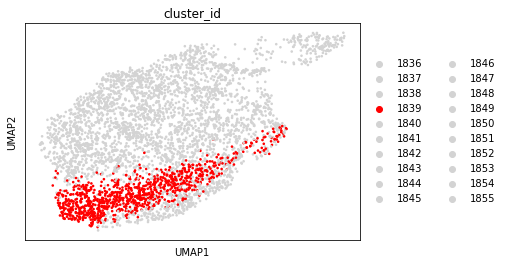

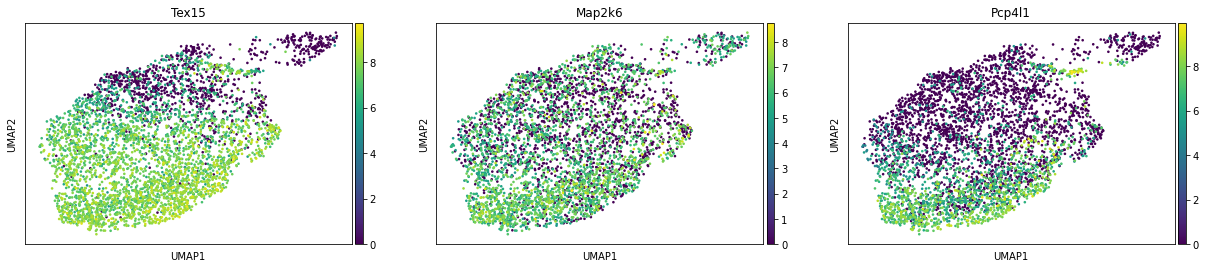

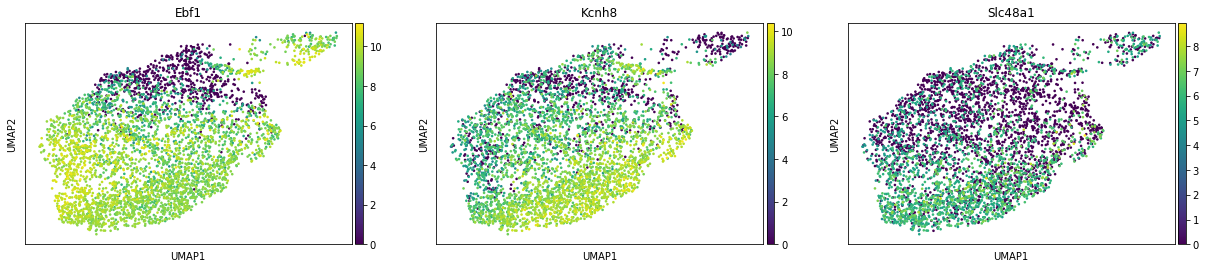

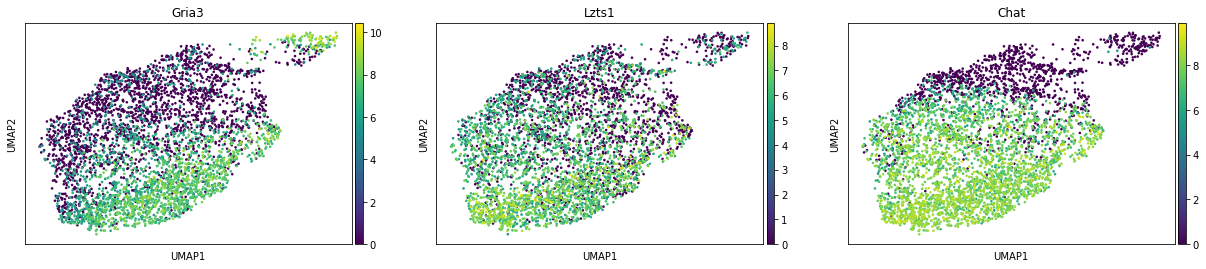

In [20]:
# Plot expression of several potential marker genes
maskPalette = create_mask_dict(clData.obs.cluster_id.unique(),indx)
sc.pl.embedding(clData, "umap", color = "cluster_id", palette=maskPalette)

sc.pl.umap(clData, color = clFiltered["names"][0:3])
sc.pl.umap(clData, color = clFiltered["names"][3:6])
sc.pl.umap(clData, color = clFiltered["names"][190:194])

## Other stuff

In [ ]:
# Link to Allen ISH
# Pouf1 is a known marker of medial habenula
https://mouse.brain-map.org/experiment/show/74641304

# Orpm1 (highly expressed in cluster 1851) seems to label a subcluster of medial habenula
https://mouse.brain-map.org/experiment/show/79912572

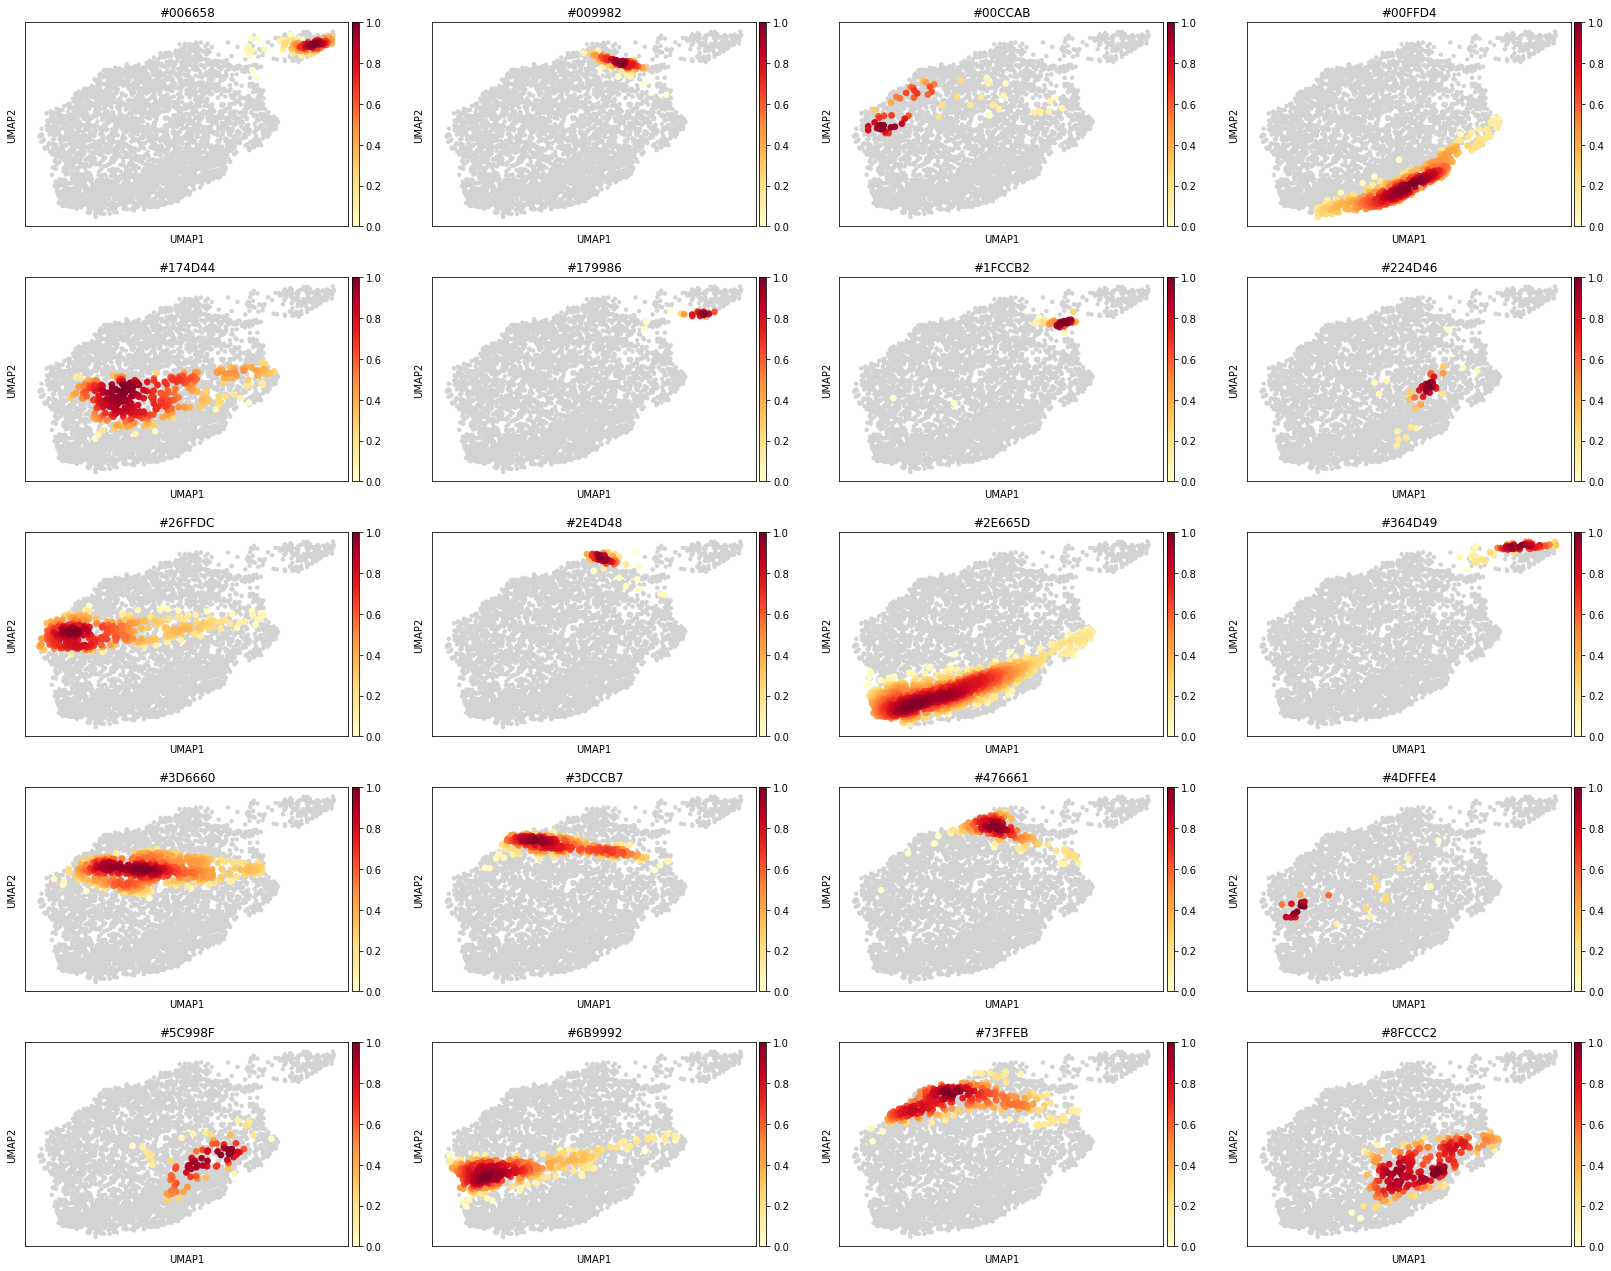

In [27]:
# Embedding densitt key seems to break down for fully numeric names, grouping by cluster color seems to work though
sc.tl.embedding_density(clData, basis="umap",groupby="cluster_color")
sc.pl.embedding_density(clData, basis="umap", key="umap_density_cluster_color")

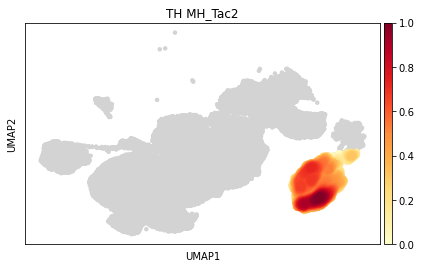

In [29]:
sc.tl.embedding_density(gluData, basis="umap", groupby="subclass_label")
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label", group=indx)